# Part 5: Recognition

In this part of the assignment, you will practice **object detection** by applying a [pre-trained YOLO model](https://pytorch.org/hub/ultralytics_yolov5/) for object detection on a new dataset. Specifically, you will use a pre-trained YOLO model to detect cars in images derived from video recording of a highway. You will evaluate the model using Intersection over Union (IoU) and recall metrics.

**Learning objectives.** You will:
1. Apply a pre-trained YOLO model for object detection on a new dataset.
2. Evaluate the model using IoU and recall metrics.
3. Consider the ethical implications surrounding bias and privacy for facial recognition software as one example of object detection in the real world.

YOLO (You Only Look Once) is a popular object detection algorithm that is known for its speed and accuracy. YOLO divides the image into a grid and predicts bounding boxes and class probabilities for each grid cell. The model predicts the bounding boxes and class probabilities simultaneously, which makes it faster than other object detection algorithms. YOLO has several versions, such as YOLOv1, YOLOv2, YOLOv3, and YOLOv4. In this assignment, you will use YOLOv5, which is a popular version of the YOLO model. You can [read more about the model and its architecture here](https://docs.ultralytics.com/yolov5/) if you are interested; you will find that it is a deep neural network that uses convolutional layers extensively, among other things.

First, the following code loads the dataset of car images and stores them in a dictionary keyed by the image id.

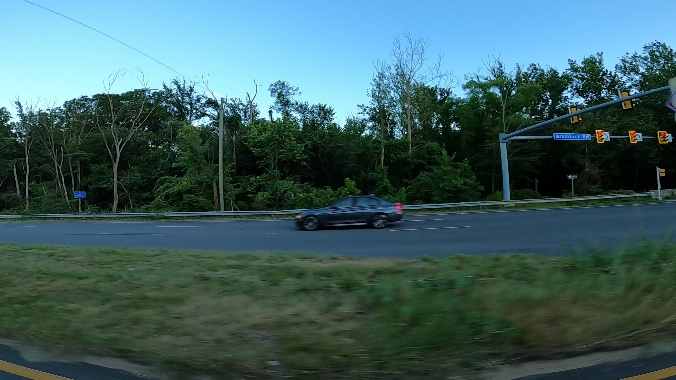

In [4]:
# Run but DO NOT MODIFY this code

# load car images and visualize a sample image
import os
from PIL import Image

# stores images in a dictionary keyed by image_id
path = 'car/car_images'
image_dict = {}
for file in os.listdir(path):
    if file.endswith('.jpg'):
        image_id = file.split('.')[0]
        image = Image.open(os.path.join(path, file))
        image_dict[image_id] = image

image_dict['vid_4_600']

Next, the following code reads the ground truth bounding box information for cars in all of the images. There may be multiple cars in a single image, in which case the dataset has multiple rows, one per car, just sharing the same image id. Images are identified with the same ids as above.

The code as written uses the [Pandas library](https://pandas.pydata.org/). If you prefer not to work with Pandas you are welcome to instead use the Python standard library [csv module](https://docs.python.org/3/library/csv.html) or NumPy to read the data into a structure of your preference.

In [5]:
# load car bounding boxes
import pandas as pd
bounding_boxes = pd.read_csv('car/car_bounding_boxes.csv')
bounding_boxes.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


## Task 1

Below we import a pretrained YOLO model. If you are unable to load the model due to a missing dependency (for example, the model needs access to the `cv2` module for computer vision) then you can try running the following command in a separate notebook cell by itself to attempt to install the dependencies: `pip install -U ultralytics`.

In [6]:
# load pre-trained Yolo model

import torch
import warnings
warnings.filterwarnings("ignore")
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in /home/users/ab992/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-3-7 Python-3.11.5 torch-2.1.0 CUDA:0 (Tesla P100-PCIE-12GB, 12187MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Once you have loaded the model, use it on any image containing at least one car. Visualize the predicted bounding box on the image. You can see an [example of the basic model usage here](https://pytorch.org/hub/ultralytics_yolov5/#load-from-pytorch-hub); note that running the model returns a custom results object that can be visualized directly with `.show()`.

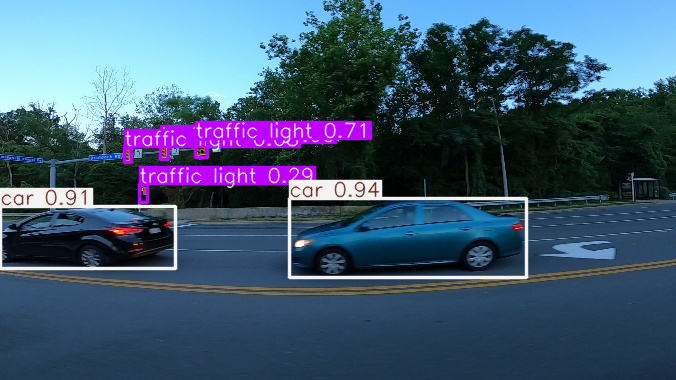

In [8]:
images = 'car/car_images/vid_4_720.jpg'
results = model(images)
results.show()

## Task 2

The standard way to measure the correctness of a bounding box prediction in object detection is the intersection-over-union (IoU). Given a ground truth bounding box $B$ and a predicted bounding box $\hat{B}$, the IoU is the area of the *intersection* of $B$ and $\hat{B}$ (the number of pixels included in both) divided by the *union* of $B$ and $\hat{B}$ (the total number of pixels included in either). IoU should always be a value between 0 and 1, with larger scores indicating better bounding box predictions.

For this task, implement the `intersect_over_union` function below to calculate the IoU metric. You should then **test your implementation** before moving on, reporting at least 3 examples used for testing.

In [9]:
def intersect_over_union(ground_truth, pred):
    x1_gt, y1_gt, x2_gt, y2_gt = ground_truth
    x1_pred, y1_pred, x2_pred, y2_pred = pred

    x_left, y_top = max(x1_gt, x1_pred), max(y1_gt, y1_pred)
    x_right, y_bottom = min(x2_gt, x2_pred), min(y2_gt, y2_pred)

    if x_right <= x_left or y_bottom <= y_top:
        return 0.0

    inter_area = (x_right - x_left) * (y_bottom - y_top)
    union_area = (x2_gt - x1_gt) * (y2_gt - y1_gt) + (x2_pred - x1_pred) * (y2_pred - y1_pred) - inter_area

    return inter_area / union_area if union_area > 0 else 0.0

In [10]:
examples = [
    ((10, 10, 50, 50), (10, 10, 50, 50)),  # identical
    ((10, 10, 50, 50), (30, 30, 70, 70)), # some overlap
    ((10, 10, 50, 50), (60, 60, 100, 100))  # no overlap
    ]

for i, (gt, pred) in enumerate(examples, 1):
    print(f"Test {i}: IoU =", intersect_over_union(gt, pred))


Test 1: IoU = 1.0
Test 2: IoU = 0.14285714285714285
Test 3: IoU = 0.0


## Task 3

Evaluate the YOLO model by computing and reporting the **recall** of the model's bounding box predictions for cars (and only cars) on the entire dataset. Recall that the recall is the fraction of cars that are correctly detected by the model. A couple things to note:

1. There may be multiple ground truth cars in a given image. When there are multiple cars in a given image, treat each one separately, so that the recall is over all appearances of cars in all images in the dataset.
2. Use the intersection over union metric to determine if a car is correctly detected. Specifically, consider a prediction to be a true positive if the IoU is at least $0.5.$

In [11]:
image_ids = bounding_boxes['image'].unique()
total_ground_truth = len(bounding_boxes)  
detected_count = 0

for image_id in image_ids:
    image_path = os.path.join('car/car_images', image_id)
    results = model(image_path)

    preds_df = results.pandas().xyxy[0]  
    car_preds = preds_df[preds_df['name'] == 'car']  

    gt_boxes = bounding_boxes[bounding_boxes['image'] == image_id]  

    for _, gt_row in gt_boxes.iterrows():  
        gt_box = (gt_row['xmin'], gt_row['ymin'], gt_row['xmax'], gt_row['ymax'])
        for _, pred_row in car_preds.iterrows():
            pred_box = (pred_row['xmin'], pred_row['ymin'], pred_row['xmax'], pred_row['ymax'])
            if intersect_over_union(gt_box, pred_box) >= 0.5:
                detected_count += 1
                break  

recall = detected_count / total_ground_truth
print("Car detection recall:", recall)

Car detection recall: 0.9409660107334525


## Task 4

You may have heard of **facial recognition** software: These are essentially models for object detection and recognition that are trained to detect and recognize human faces. Such models have been deployed in law enforcement and, for example, [US Customs when entering the country](https://www.cbp.gov/travel/biometrics).

Such adoption has happened despite serious ethical objections concerning bias and privacy. For example, [Gender Shades by Buolamwini and Gebru, 2018](https://proceedings.mlr.press/v81/buolamwini18a.html) was a landmark audit study of commercially available facial recognition software that demonstrated substantial disparities in performance based on skin color. 

In 2021, Marks observes in a [Communications of the ACM Article](https://cacm.acm.org/news/can-the-biases-in-facial-recognition-be-fixed-also-should-they/) cases of individuals wrongly accused of crimes on the basis of facial recognition software, including software developed using 2.8 billion scraped images from social media without user permission, raising further questions about privacy. 

Of course, others might argue that properly trained and debiased models might be used to build a safer (by helping to find criminal suspects) or more convenient society (replacing, for example, paper passports). Walsh, in a [2022 article](https://cacm.acm.org/opinion/the-troubling-future-for-facial-recognition-software/) considers a variety of perspectives including the threat of constant surveillance but also the potential for applications of societal benefit.

In 2-3 paragraphs, take a position on the question "Should governments use facial recognition software?" You might argue yes for some purposes but no for others, or that it depends on how the technology is developed or regulated; explain your view referencing any of the above articles or other sources of your own choosing.

Personally, I think that while it obviously depends on which government we are talking about, in general governments should approach the use of facial recognition software with caution. It is important to recognize both its potential benefits and significant risks. On one hand, facial recognition can improve public security in specific contexts, like identifying criminals or locating missing people. In highly controlled environments like airports or public events, where security is critical, this technology can help prevent terrorism, criminal activities, and identify threats in real-time. Its ability to quickly verify identities in large crowds cannot be understated. From this perspective, facial recognition is a good thing. 

However, the widespread and unregulated use of facial recognition by governments is very concerning. Without strict regulations, the technology can be used to monitor people without their consent, violating personal privacy and leading to injustices like tracking dissidents or marginalized groups. As noted in the article on interpretable vs. explainable machine learning models, technology that lacks transparency can result in biases or inaccuracies, which may unfairly target certain populations. Additionally, facial recognition software has been shown to perform less accurately for people of color and women, amplifying existing societal biases and injustices. So overall, I think that governments should implement strong legal safeguards and transparency to prevent discrimination and to ensure accountability. Otherwise, I think the risks of abuse outweigh the potential benefits. 